In [2]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [3]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [4]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [5]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


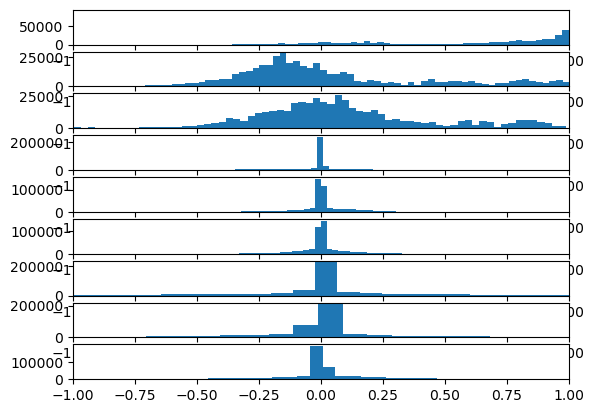

In [6]:
# plot distributions
plot_distributions(trainX)

In [7]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

[ LSTM ]

In [8]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 36s 314ms/step - loss: 1.2678 - accuracy: 0.4657 - val_loss: 0.9822 - val_accuracy: 0.6479
Epoch 2/10
92/92 [==============================] - 28s 308ms/step - loss: 0.8181 - accuracy: 0.6514 - val_loss: 0.8270 - val_accuracy: 0.7104
Epoch 3/10
92/92 [==============================] - 28s 304ms/step - loss: 0.6400 - accuracy: 0.7235 - val_loss: 0.7666 - val_accuracy: 0.7505
Epoch 4/10
92/92 [==============================] - 28s 300ms/step - loss: 0.4789 - accuracy: 0.8140 - val_loss: 0.6458 - val_accuracy: 0.8185
Epoch 5/10
92/92 [==============================] - 33s 362ms/step - loss: 0.3546 - accuracy: 0.8800 - val_loss: 0.5580 - val_accuracy: 0.8409
Epoch 6/10
92/92 [==============================] - 28s 302ms/step - loss: 0.2813 - accuracy: 0.9099 - val_loss: 0.4912 - val_accuracy: 0.8844
Epoch 7/10
92/92 [==============================] - 34s 369ms/step - loss: 0.2535 - accuracy: 0.9152 - val_loss: 0.4996 - val_accuracy: 0.8736

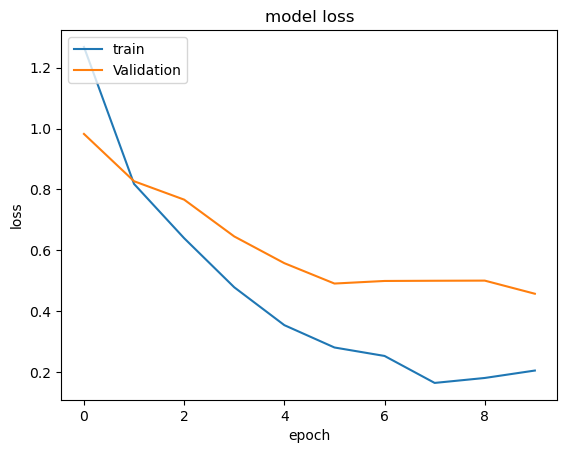

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [12]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8842890858650208
93/93 [==============================] - 9s 87ms/step


In [13]:
predictions

array([[2.30589276e-03, 4.94747376e-03, 1.06575266e-04, 5.45288948e-03,
        9.87167180e-01, 2.00242102e-05],
       [1.51282316e-03, 3.52468714e-03, 7.17997318e-05, 4.24537342e-03,
        9.90633249e-01, 1.20882050e-05],
       [1.44632440e-03, 3.63121810e-03, 6.93191032e-05, 3.79405101e-03,
        9.91047919e-01, 1.12747111e-05],
       ...,
       [1.48085319e-02, 9.84393895e-01, 5.71028912e-04, 9.30014176e-06,
        2.15857435e-04, 1.45497984e-06],
       [2.23463196e-02, 9.76372063e-01, 7.35500245e-04, 2.48152883e-05,
        5.15946420e-04, 5.33563934e-06],
       [1.61930006e-02, 9.82626438e-01, 5.03495103e-04, 2.37056520e-05,
        6.47964946e-04, 5.46023512e-06]], dtype=float32)

In [14]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[450  11  32   0   3   0]
 [ 28 426  15   0   0   2]
 [  1   1 418   0   0   0]
 [  1  21   0 359 110   0]
 [  2  11   0  44 475   0]
 [  0  43   0  16   0 478]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.93      0.91      0.92       496
           2       0.83      0.90      0.87       471
           3       0.90      1.00      0.94       420
           4       0.86      0.73      0.79       491
           5       0.81      0.89      0.85       532
           6       1.00      0.89      0.94       537

    accuracy                           0.88      2947
   macro avg       0.89      0.89      0.88      2947
weighted avg       0.89      0.88      0.88      2947



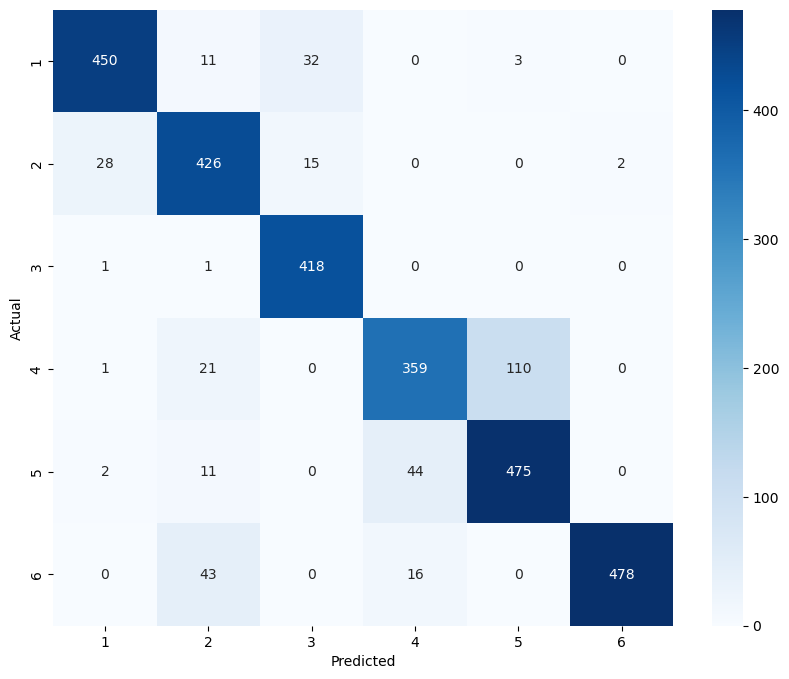

In [15]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

[ CNN ]

In [16]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 11s 93ms/step - loss: 0.5223 - accuracy: 0.7875 - val_loss: 0.3610 - val_accuracy: 0.8885
Epoch 2/20
92/92 [==============================] - 8s 85ms/step - loss: 0.1617 - accuracy: 0.9359 - val_loss: 0.2381 - val_accuracy: 0.9028
Epoch 3/20
92/92 [==============================] - 8s 84ms/step - loss: 0.0998 - accuracy: 0.9566 - val_loss: 0.2300 - val_accuracy: 0.9245
Epoch 4/20
92/92 [==============================] - 7s 76ms/step - loss: 0.0956 - accuracy: 0.9585 - val_loss: 0.2359 - val_accuracy: 0.9177
Epoch 5/20
92/92 [==============================] - 8s 82ms/step - loss: 0.0848 - accuracy: 0.9599 - val_loss: 0.2689 - val_accuracy: 0.9198
Epoch 6/20
92/92 [==============================] - 8s 87ms/step - loss: 0.0903 - accuracy: 0.9580 - val_loss: 0.2532 - val_accuracy: 0.9198
Epoch 7/20
92/92 [==============================] - 8s 82ms/step - loss: 0.0721 - accuracy: 0.9660 - val_loss: 0.2919 - val_accuracy: 0.9109
Epoch 8/20
9

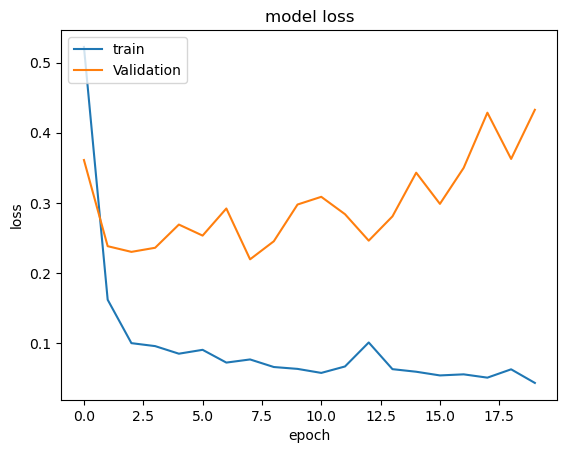

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [20]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.9066847562789917
93/93 [==============================] - 1s 11ms/step


**** Confusion Matrix ****
[[466   8  21   1   0   0]
 [ 18 428  20   0   0   5]
 [  2   8 410   0   0   0]
 [  0   2   0 415  68   6]
 [  0   2   0 114 416   0]
 [  0   0   0   0   0 537]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.96      0.94      0.95       496
           2       0.96      0.91      0.93       471
           3       0.91      0.98      0.94       420
           4       0.78      0.85      0.81       491
           5       0.86      0.78      0.82       532
           6       0.98      1.00      0.99       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



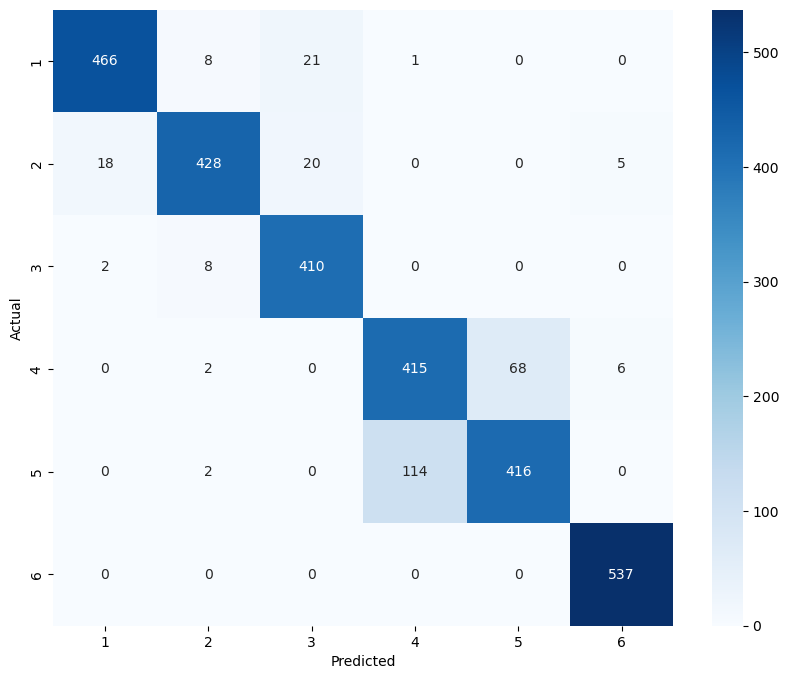

In [21]:
display_results(testy,predictions,classNames)

In [22]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [23]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

1/1 [==============================] - 0s 57ms/step


In [24]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ",sampleActualClass[0])
print("Predicted class: ",samplePredictedClass[0])

Actual class:  4
Predicted class:  4
